In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.insert(0, '..')
import tensorflow as tf
import tf_slim as slim
from graphgan.utils import get_3d_direction
from graphgan.layers import *
from graphgan.gradient_penalty import gradient_penaly
from graphgan.datasets import graph_input_fn
from graphgan.datasets import project_ellipticities, project_3d_shape, project_ellipticities_np
from astropy.table import Table, join
from functools import partial
from halotools_ia.correlation_functions  import ed_3d,ee_3d, ed_3d_one_two_halo_decomp
print(" Available: ",  (tf.config.list_physical_devices('GPU')))
from sklearn.preprocessing import RobustScaler
 

Populating the interactive namespace from numpy and matplotlib



 Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pickle
from pandas import *
mb2 = Table.read('/hildafs/home/yjagvara/graphs4ia/MB2_subfind_z_1.0_small.hdf5' )
mb2 = mb2[log10(mb2['halos.m_star']*10**10)>9]
tng = pickle.load(  open('/hildafs/projects/phy200017p/yjagvara/some_data/TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP_only_cent.pkl', "rb" ) )

#tng = Table.from_pandas(DataFrame(tng))
tng = tng[tng['dm_mass']>0]
tng = tng[[log10(tng['dm_mass']*10**10)>9]]
tng = tng[[log10(tng['mass']*10**10)>9]]
tng['q'] = tng['b']/tng['a']
tng['s'] = tng['c']/tng['a']

/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/astropy/table/table.py:1145: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]
/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/numpy/ma/core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/numpy/ma/core.py:3257: FutureWarning: Using a non-tuple sequence for multidimensional indexing is 

In [3]:
tng

gal_id,a,b,c,av_x,av_y,av_z,bv_x,bv_y,bv_z,cv_x,cv_y,cv_z,tid_av_x_0.1_1024,tid_av_y_0.1_1024,tid_av_z_0.1_1024,tid_bv_x_0.1_1024,tid_bv_y_0.1_1024,tid_bv_z_0.1_1024,tid_cv_x_0.1_1024,tid_cv_y_0.1_1024,tid_cv_z_0.1_1024,tid_a_0.1_1024,tid_b_0.1_1024,tid_c_0.1_1024,tid_av_x_0.5_1024,tid_av_y_0.5_1024,tid_av_z_0.5_1024,tid_bv_x_0.5_1024,tid_bv_y_0.5_1024,tid_bv_z_0.5_1024,tid_cv_x_0.5_1024,tid_cv_y_0.5_1024,tid_cv_z_0.5_1024,tid_a_0.5_1024,tid_b_0.5_1024,tid_c_0.5_1024,tid_av_x_1.0_1024,tid_av_y_1.0_1024,tid_av_z_1.0_1024,tid_bv_x_1.0_1024,tid_bv_y_1.0_1024,tid_bv_z_1.0_1024,tid_cv_x_1.0_1024,tid_cv_y_1.0_1024,tid_cv_z_1.0_1024,tid_a_1.0_1024,tid_b_1.0_1024,tid_c_1.0_1024,tid_av_x_2.0_1024,tid_av_y_2.0_1024,tid_av_z_2.0_1024,tid_bv_x_2.0_1024,tid_bv_y_2.0_1024,tid_bv_z_2.0_1024,tid_cv_x_2.0_1024,tid_cv_y_2.0_1024,tid_cv_z_2.0_1024,tid_a_2.0_1024,tid_b_2.0_1024,tid_c_2.0_1024,mass,GroupID,tot_mass,dm_mass,central_bool,group_mass,group_x,group_y,group_z,gal_pos_x,gal_pos_y,gal_pos_z,dm_av_x,dm_av_y,dm_av_z,dm_bv_x,dm_bv_y,dm_bv_z,dm_cv_x,dm_cv_y,dm_cv_z,dm_a,dm_b,dm_c,mlp_av_x,mlp_av_y,mlp_av_z,q,s
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.24562844247483243,0.11233008826530698,0.09435347356932028,0.15057356009311798,-0.36432524666271543,0.9190183445639349,-0.6040801058750838,0.7019725376704176,0.37725559246020707,0.7825693762771655,0.611965416507098,0.11438312949234405,0.8275753855705261,0.5501617810833461,-0.11153932645318682,-0.4364806852752775,0.7555949692944677,0.4884269175204382,0.3529923768186143,-0.355525325415916,0.8654467776217399,1054.244087225318,991.9027130436707,668.0261137005616,-0.9183833599090576,0.33972494317589014,0.20287679547321114,0.33534699111399274,0.9403888675675559,-0.05666721544068841,-0.2100343464963115,0.015991896046057438,-0.9775632115381181,59.10935058615099,55.377614125575626,37.975054282341716,0.9371282458305359,0.1784244452709745,-0.29992566920893826,-0.2053100234179685,0.9768323454844315,-0.06038512316371721,0.2822029128212493,0.11816634946180396,0.9520494891811419,13.122050507836377,11.700347539646893,9.282237732126015,-0.8248880505561829,0.33217499988277654,0.4574051124728157,0.5063412900419841,0.7939398479662237,0.3365679958195495,-0.2513526714837356,0.5092340201363678,-0.8231054290148635,2.5250096232145673,2.341083724345102,1.7858375325765965,251.0163116455078,0.0,27477.935546875,23325.619140625,1.0,38878.03515625,849.0914306640625,26326.99609375,18306.93359375,0.8490914106369019,26.326995849609375,18.306934356689453,0.20913785733198287,-0.2376266091458571,0.9485752217175131,-0.0291868731156354,0.9680772186306577,0.24894703293283385,0.9774505015950008,0.07975019369363229,-0.19552601754628252,0.7422561814889702,0.380580342545896,0.2953753041796042,-0.8295962810516357,0.51895672082901,0.5298088788986206,0.4573171051915803,0.3841308955048556
1.0,0.08088470650058953,0.04497213832247513,0.03777383880658522,-0.9840750455762398,-0.006859759853817557,0.17762108086843106,0.07866214907516236,0.8792771126813137,0.46977018361927686,-0.15940066178344028,0.4762611707976621,-0.8647350612837673,-0.25285616517066956,-0.542943046543665,-0.8007974784346137,-0.0015899779481896464,-0.8274600252025045,0.5615223759228073,0.9675025711735737,-0.14325765215776112,-0.20836511193280413,340.0297044488053,304.0921077455601,251.82406385313607,-0.4318984

In [4]:
def project_shape(a3d, b3d, c3d, q3d, s3d):
 
 
    s = tf.stack([a3d, b3d, c3d])
    print(s.get_shape().as_list())
    w = tf.stack([tf.ones_like(q3d), q3d, s3d])
 

    k = tf.reduce_sum(s[:,:,0:2]*tf.expand_dims(s[:,:,2], axis=-2) / tf.expand_dims(w[:,:]**2, axis=-2), axis=0)
    a2 =tf.reduce_sum(s[:,:,2]**2/w[:,:]**2, axis=0)
 
    print(s[:,:,0:2,...].get_shape().as_list())
    Winv = tf.reduce_sum(tf.einsum('ijko,ijlo->ijklo', s[:,:,0:2,...], s[:,:,0:2,...]) / tf.expand_dims(tf.expand_dims(w[:,:]**2,-2),-2), axis=0) - tf.einsum('ijo,iko->ijko', k,k)/tf.expand_dims(tf.expand_dims(a2,-2),-2)
    W = tf.linalg.inv(tf.squeeze( tf.transpose(Winv) ))
    d = tf.sqrt(tf.linalg.det(W))
 
    e1 = (W[:,0,0] - W[:,1,1])/( W[:,0,0] + W[:,1,1] + 2*d)
    e2 = 2 * W[:,0,1]/( W[:,0,0] + W[:,1,1] + 2*d)
 
    return tf.stack([e1, e2], axis=-1)

In [5]:
a3d = np.array([[tng['dm_av_x'] , tng['dm_av_y'] , tng['dm_av_z'] ]])
b3d = np.array([[tng['dm_bv_x'] , tng['dm_bv_y'] , tng['dm_bv_z'] ]])
c3d = np.array([[tng['dm_cv_x'] , tng['dm_cv_y'] , tng['dm_cv_z'] ]])
q3d = np.array([tng['dm_b'] /tng['dm_a'] ])
s3d = np.array([tng['dm_c'] /tng['dm_a'] ])
    
e12_modif = project_shape(a3d, b3d, c3d, q3d, s3d)

[3, 1, 3, 17457]
[3, 1, 2, 17457]


In [6]:
a3d.shape

(1, 3, 17457)

(array([7.420e+02, 1.845e+03, 2.516e+03, 2.596e+03, 2.277e+03, 1.900e+03,
        1.533e+03, 1.171e+03, 7.760e+02, 5.930e+02, 4.470e+02, 3.040e+02,
        2.180e+02, 1.640e+02, 9.900e+01, 8.500e+01, 6.000e+01, 3.800e+01,
        3.100e+01, 2.300e+01, 1.200e+01, 7.000e+00, 7.000e+00, 5.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([0.0007715 , 0.01961999, 0.03846848, 0.05731698, 0.07616547,
        0.09501396, 0.11386245, 0.13271094, 0.15155944, 0.17040793,
        0.18925642, 0.20810491, 0.2269534 , 0.2458019 , 0.26465039,
        0.28349888, 0.30234737, 0.32119586, 0.34004436, 0.35889285,
        0.37774134, 0.39658983, 0.41543833, 0.43428682, 0.45313531,
        0.4719838 , 0.49083229, 0.50968079, 0.52852928, 0.54737777,
        0.56622626]),
 <a list of 30 Patch objects>)

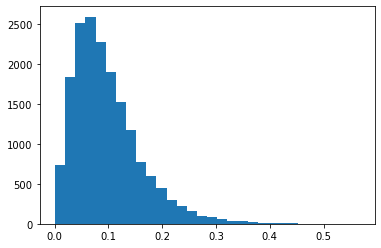

In [7]:
hist(np.sqrt(e12_modif[:,0]**2+e12_modif[:,1]**2),bins=30 )

In [8]:
hist2d(e12_modif[:,1], tng['dm_e2_np'],bins=100,norm=matplotlib.colors.LogNorm())

KeyError: 'dm_e2_np'

In [9]:


# Reoriente all galaxies with respect to the tidal field
# Pre-processing the orientation of galaxies with respect to their host haloes and the tidal field

# Computes the size of groups
gids, idx, inv, counts  = np.unique(tng['GroupID'],  return_index=True, return_inverse=True, return_counts=True)
tng['group_size'] = counts[inv]

# Convert distances to Mpc
# tng['gal_pos_x'] /= 1000.
# tng['gal_pos_y'] /= 1000.
# tng['gal_pos_z'] /= 1000.

tng['group_x'] /= 1000.
tng['group_y'] /= 1000.
tng['group_z'] /= 1000.

# Computes direction to the central
tng['cen_x'] = tng['group_x'][idx][inv] - tng['gal_pos_x']
tng['cen_y'] = tng['group_y'][idx][inv] - tng['gal_pos_y']
tng['cen_z'] = tng['group_z'][idx][inv] - tng['gal_pos_z']
ncen = np.sqrt(tng['cen_x']**2 + tng['cen_y']**2 + tng['cen_z']**2 ) 
tng['cen_r'] = ncen

inds_cent = ncen == 0
ncen[ncen == 0] = 1
tng['cen_x'] = tng['cen_x']/ncen
tng['cen_y'] = tng['cen_y']/ncen
tng['cen_z'] = tng['cen_z']/ncen

# # First reorienting the tidal 
a = (tng['tid_av_x_0.1_1024']*tng['cen_x'] +
     tng['tid_av_y_0.1_1024']*tng['cen_y'] +
     tng['tid_av_z_0.1_1024']*tng['cen_z'])

# According to the sign, decide to reverse the orientation of
flip_a = ones_like(a)
flip_a[where(a < 0)] *= -1.0
tng['tid_av_x_0.1_1024'] *= flip_a
tng['tid_av_y_0.1_1024'] *= flip_a
tng['tid_av_z_0.1_1024'] *= flip_a
tng['tid_bv_x_0.1_1024'] *= flip_a
tng['tid_bv_y_0.1_1024'] *= flip_a
tng['tid_bv_z_0.1_1024'] *= flip_a

# Computing angle with respect to the tidal field,
# adjusting the axes to have the same orientation
aTid = (tng['dm_av_x']*tng['tid_cv_x_0.1_1024'] +
        tng['dm_av_y']*tng['tid_cv_y_0.1_1024'] +
        tng['dm_av_z']*tng['tid_cv_z_0.1_1024'])
bTid = (tng['dm_bv_x']*tng['tid_cv_x_0.1_1024'] +
        tng['dm_bv_y']*tng['tid_cv_y_0.1_1024'] +
        tng['dm_bv_z']*tng['tid_cv_z_0.1_1024'])
cTid = (tng['dm_cv_x']*tng['tid_cv_x_0.1_1024'] +
        tng['dm_cv_y']*tng['tid_cv_y_0.1_1024'] +
        tng['dm_cv_z']*tng['tid_cv_z_0.1_1024'])
caTid = (tng['dm_cv_x']*tng['tid_av_x_0.1_1024'] +
         tng['dm_cv_y']*tng['tid_av_y_0.1_1024'] +
         tng['dm_cv_z']*tng['tid_av_z_0.1_1024'])

# According to the sign, decide to reverse the orientation of
# the dark matter halo by rotating around b or c
flip_a = ones_like(aTid)
flip_a[where(aTid < 0)] *= -1.0
flip_c = ones_like(cTid)
flip_c[where(caTid < 0)] *= -1.0
flip_b = ones_like(bTid)
flip_b = flip_a * flip_c

# Apply rotation around c, thus preserving the sign of c
aTid *= flip_a
bTid *= flip_b
cTid *= flip_c

# Update the DM halo orientation
tng['dm_av_x'] *= flip_a
tng['dm_av_y'] *= flip_a
tng['dm_av_z'] *= flip_a
tng['dm_bv_x'] *= flip_b
tng['dm_bv_y'] *= flip_b
tng['dm_bv_z'] *= flip_b
tng['dm_cv_x'] *= flip_c
tng['dm_cv_y'] *= flip_c
tng['dm_cv_z'] *= flip_c

# Compute misalignment of stellar component in same rotated frame
a = (tng['dm_av_x']*tng['av_x'] +
     tng['dm_av_y']*tng['av_y'] +
     tng['dm_av_z']*tng['av_z'])
b = (tng['dm_bv_x']*tng['av_x'] +
     tng['dm_bv_y']*tng['av_y'] +
     tng['dm_bv_z']*tng['av_z'])
c = (tng['dm_cv_x']*tng['av_x'] +
     tng['dm_cv_y']*tng['av_y'] +
     tng['dm_cv_z']*tng['av_z'])
cc = (tng['dm_cv_x']*tng['cv_x'] +
      tng['dm_cv_y']*tng['cv_y'] +
      tng['dm_cv_z']*tng['cv_z'])

# Apply rotation to the Stellar shape frame to match DM frame
flip_a_stel = ones_like(a)
flip_a_stel[where(a < 0)] *= -1.0
flip_c_stel = ones_like(cc)
flip_c_stel[where(cc < 0)] *= -1.0
flip_b_stel = flip_a_stel * flip_c_stel

# Rotation around c, leaving c unchanged
# Rotation around a, leaving a unchanged
a *= flip_a_stel
b *= flip_b_stel
c *= flip_c_stel

# Update the Stellar halo orientation
tng['av_x'] *= flip_a_stel
tng['av_y'] *= flip_a_stel
tng['av_z'] *= flip_a_stel
tng['bv_x'] *= flip_b_stel
tng['bv_y'] *= flip_b_stel
tng['bv_z'] *= flip_b_stel
tng['cv_x'] *= flip_c_stel
tng['cv_y'] *= flip_c_stel
tng['cv_z'] *= flip_c_stel

In [10]:
# Doing some preprocessing
tng['tot_mass'] = log10(tng['tot_mass']*1e10)
tng['group_mass'] = log10(tng['group_mass']*1e10)
tng['mass'] = log10(tng['mass']*1e10)#*1e10+1)
tng['dm_mass'] = log10(tng['dm_mass']*1e10)#*1e10+1)

In [11]:
catalog = tng

In [12]:
catalog['dm_mass_scaled'] = clip(RobustScaler().fit_transform(catalog['dm_mass'].reshape((-1,1))),-5,5).squeeze()
catalog['mass_scaled'] = clip(RobustScaler().fit_transform(catalog['mass'].reshape((-1,1))),-5,5).squeeze()
catalog['group_mass_scaled'] = clip(RobustScaler().fit_transform(catalog['group_mass'].reshape((-1,1))),-5,5).squeeze()

In [13]:
weighting='exp'
directions = get_3d_direction()
filter_size=directions.shape[-1]
tf.compat.v1.enable_eager_execution()
# Define generator function
def conditional_generator_fn(inputs, 
                             is_training=True,
                             reuse=None,
                             scope='Generator',
                             fused_batch_norm=False):

    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = inputs
    # W_i matrices define the sprase matrix to construct adjecency
    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    # Computes 3D adjacency matrix
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, radial_scale=0.4,
                           learn_scale=False)

    # Input level, transforming all inputs features into a single channel
    # First we mix the inputs
    net = graph_conv2(tf.concat([noise, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=64,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    
    # Let's constrain the output to lie on the sphere, predicting major axis of the galaxy (unit vector)
    net_a2d = graph_conv2(net, mr, 2, activation_fn=None, one_hop=False)
    net_a2d = tf.nn.l2_normalize(net_a2d, axis=-1)
    
    # Assemble output, 
    out_net = tf.concat([net_a2d], axis=1)

    return out_net

def conditional_discriminator_fn(y, conditioning):
    """
    Discriminator network that can tell if the galaxies are correctly aligned
    args:
    y: alignment signal
    conditioning: tuple (adj, idn, x_spatial, pool, x, noise)
    """
    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = conditioning
    #pm_i are the pooling matrices, also sparse
    
    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    pool = tf.SparseTensor(tf.cast(pm0, tf.int64), pm1, pm2)
    
    # Computes 3D adjacency matrices for each multi-resolution level
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, learn_scale=False, 
                           radial_scale=0.2)
    #print(len(mr))
    #print(y)
    #print(y.get_shape().as_list())
    if y.get_shape().as_list()[1] > 2: 
        
        #y = tf.transpose(y)
        #print(tf.expand_dims(tf.transpose(y[...,2:5]),axis=0).get_shape().as_list())
        #print(y.get_shape().as_list())
        
        y = project_3d_shape(tf.expand_dims(tf.transpose(y[...,2:5]),axis=0) , tf.expand_dims(tf.transpose(y[...,5:8]),axis=0), 
                        tf.expand_dims(tf.transpose(y[...,8:11]),axis=0), tf.expand_dims(tf.transpose(y[...,0]),axis=0), tf.expand_dims(tf.transpose(y[...,1]),axis=0))
        
        
       # print('3D')
        #y = project_3d_shape(tf.slice(y, 2, 3), tf.slice(y, 5,3), tf.slice(y, 8,3), tf.slice(y, 0,1), tf.slice(y, 1,1))               
        #print(y.get_shape().as_list()[1])   
    #check if y is 2d:
       # if false: projection, feed it into networks, y =y_projected
        #one problem tf may complain y having different shapes  
       # print(y)
       # print(X)
       # print(tf.concat([y, X],axis=1))
    #print('This is interesting: ',y.get_shape().as_list())
    net = graph_conv2(tf.concat([y, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 64, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 32, activation_fn=tf.nn.leaky_relu)

    # Apply spatial pooling, MeanPooling
    net = tf.compat.v1.sparse_tensor_dense_matmul(pool, net)

    net = slim.fully_connected(net, 1, activation_fn=None)
    
    return net

weighting='exp'
directions = get_3d_direction()
filter_size=directions.shape[-1]

# Define generator function
def conditional_generator_fn(inputs, 
                             is_training=True,
                             reuse=None,
                             scope='Generator',
                             fused_batch_norm=False):

    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = inputs
    # W_i matrices define the sprase matrix to construct adjecency
    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    # Computes 3D adjacency matrix
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, radial_scale=0.4,
                           learn_scale=False)

    # Input level, transforming all inputs features into a single channel
    # First we mix the inputs
    net = graph_conv2(tf.concat([noise, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=64,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    
    # Let's constrain the output to lie on the sphere, predicting major axis of the galaxy (unit vector)
    net_a3d = graph_conv2(net, mr, 11, activation_fn=None, one_hop=False)
    net_a3d = tf.nn.l2_normalize(net_a3d, axis=-1)
    
    # Assemble output, 
    out_net = tf.concat([net_a3d], axis=1)

    return out_net

def conditional_discriminator_fn(y, conditioning):
    """
    Discriminator network that can tell if the galaxies are correctly aligned
    args:
    y: alignment signal
    conditioning: tuple (adj, idn, x_spatial, pool, x, noise)
    """
    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = conditioning
    #pm_i are the pooling matrices, also sparse
    
    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    pool = tf.SparseTensor(tf.cast(pm0, tf.int64), pm1, pm2)
    
    # Computes 3D adjacency matrices for each multi-resolution level
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, learn_scale=False, 
                           radial_scale=0.2)

    net = graph_conv2(tf.concat([y, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 64, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 32, activation_fn=tf.nn.leaky_relu)

    # Apply spatial pooling, MeanPooling
    net = tf.compat.v1.sparse_tensor_dense_matmul(pool, net)

    net = slim.fully_connected(net, 1, activation_fn=None)
    
    return net

In [14]:
import tensorflow_gan as tfgan
from tensorflow_gan.python import namedtuples

my_config = tf.estimator.RunConfig(
    save_summary_steps = 500,
    save_checkpoints_steps = 5000,
    keep_checkpoint_max = 500,       # Retain the 10 most recent checkpoints.
)
#tensorboard
def silly_custom_discriminator_loss(gan_model,reduction='', add_summaries=True):
    return tf.reduce_mean(gan_model.discriminator_real_outputs**2)

# Initialize GANEstimator with options and hyperparameters.
gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=conditional_generator_fn,
    discriminator_fn=conditional_discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=lambda *args, **kwargs: (tfgan.losses.wasserstein_discriminator_loss(*args, **kwargs) + 
                                                  10.*gradient_penaly(*args, **kwargs)+
                                                   0.001*silly_custom_discriminator_loss(*args, **kwargs)),   
    generator_optimizer=tf.compat.v1.train.AdamOptimizer(0.001, beta1=0., beta2=0.9),
    discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(0.001, beta1=0., beta2=0.9),
    get_hooks_fn=tfgan.get_sequential_train_hooks(train_steps=namedtuples.GANTrainSteps(3, 1)),
    model_dir='./scale_multi_Nmesh_1024_MLP-1_only_cent', 
    config=my_config)
#hooks specify how the two networks are trained each step or iteration

INFO:tensorflow:Using config: {'_model_dir': './scale_multi_Nmesh_1024_MLP-1_only_cent', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 500, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [15]:
training_fn = partial(graph_input_fn, catalog,
                      scalar_features=('mass_scaled','central_bool', 'group_mass_scaled' ), 
                      vector_features=('mlp_av_x','mlp_av_y','mlp_av_z', 'tid_av_x_0.1_1024', 'tid_av_y_0.1_1024', 'tid_av_z_0.1_1024',
                                       'tid_bv_x_0.1_1024', 'tid_bv_y_0.1_1024', 'tid_bv_z_0.1_1024',
                                       'tid_cv_x_0.1_1024', 'tid_cv_y_0.1_1024', 'tid_cv_z_0.1_1024',
                                       'tid_av_x_0.5_1024', 'tid_av_y_0.5_1024', 'tid_av_z_0.5_1024',
                                       'tid_bv_x_0.5_1024', 'tid_bv_y_0.5_1024', 'tid_bv_z_0.5_1024',
                                       'tid_cv_x_0.5_1024', 'tid_cv_y_0.5_1024', 'tid_cv_z_0.5_1024',
                                       'tid_av_x_1.0_1024', 'tid_av_y_1.0_1024', 'tid_av_z_1.0_1024',
                                       'tid_bv_x_1.0_1024', 'tid_bv_y_1.0_1024', 'tid_bv_z_1.0_1024',
                                       'tid_cv_x_1.0_1024', 'tid_cv_y_1.0_1024', 'tid_cv_z_1.0_1024'),
                      scalar_labels=('q','s'),
                      vector_labels=('dm_av_x', 'dm_av_y', 'dm_av_z',
                                    'dm_bv_x', 'dm_bv_y', 'dm_bv_z',
                                    'dm_cv_x', 'dm_cv_y', 'dm_cv_z'),
                      shuffle=True, rotate=True, repeat=True, noise_size=32, batch_size=64)

testing_fn = partial(graph_input_fn, catalog,
                      scalar_features=('mass_scaled','central_bool', 'group_mass_scaled' ),#,'tid_a_scaled','tid_b_scaled','tid_c_scaled'),
                      vector_features=('mlp_av_x','mlp_av_y','mlp_av_z','tid_av_x_0.1_1024', 'tid_av_y_0.1_1024', 'tid_av_z_0.1_1024',
                                       'tid_bv_x_0.1_1024', 'tid_bv_y_0.1_1024', 'tid_bv_z_0.1_1024',
                                       'tid_cv_x_0.1_1024', 'tid_cv_y_0.1_1024', 'tid_cv_z_0.1_1024',
                                       'tid_av_x_0.5_1024', 'tid_av_y_0.5_1024', 'tid_av_z_0.5_1024',
                                       'tid_bv_x_0.5_1024', 'tid_bv_y_0.5_1024', 'tid_bv_z_0.5_1024',
                                       'tid_cv_x_0.5_1024', 'tid_cv_y_0.5_1024', 'tid_cv_z_0.5_1024',
                                       'tid_av_x_1.0_1024', 'tid_av_y_1.0_1024', 'tid_av_z_1.0_1024',
                                       'tid_bv_x_1.0_1024', 'tid_bv_y_1.0_1024', 'tid_bv_z_1.0_1024',
                                       'tid_cv_x_1.0_1024', 'tid_cv_y_1.0_1024', 'tid_cv_z_1.0_1024'),
                      scalar_labels=('q','s'),
                      vector_labels=('dm_av_x', 'dm_av_y', 'dm_av_z',
                                    'dm_bv_x', 'dm_bv_y', 'dm_bv_z',
                                    'dm_cv_x', 'dm_cv_y', 'dm_cv_z'),
                      shuffle=False, rotate=False, repeat=False, noise_size=32, batch_size=64)
#Separately providng vector and scalar features, so as to take of of things such as rotation

#just do this on centrals , remove all of the satellites. 
#try adding tid eigenvalues

In [16]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gan_estimator.train(training_fn, steps=100000)

# [3, 1, 3, 17457]
# [3, 1, 2, 17457]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.__call__` method instead.
Tensor("custom_wasserstein_gradient_penalty/value:0", shape=(), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into ./scale_multi_Nmesh_1024_MLP-1_only_cent/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: LossTensor is inf or nan : Tensor had NaN values
	 [[node discriminator_train/train_op/CheckNumerics (defined at /hildafs/home/yjagvara/.local/lib/python3.8/site-packages/tensorflow_gan/python/contrib_utils.py:185) ]]
	 [[discriminator_train/train_op/control_dependency/Identity/_1949]]
  (1) Invalid argument: LossTensor is inf or nan : Tensor had NaN values
	 [[node discriminator_train/train_op/CheckNumerics (defined at /hildafs/home/yjagvara/.local/lib/python3.8/site-packages/tensorflow_gan/python/contrib_utils.py:185) ]]
0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node discriminator_train/train_op/CheckNumerics:
 add_3 (defined at /hildafs/home/yjagvara/.local/lib/python3.8/site-packages/tensorflow_gan/python/train.py:736)

Input Source operations connected to node discriminator_train/train_op/CheckNumerics:
 add_3 (defined at /hildafs/home/yjagvara/.local/lib/python3.8/site-packages/tensorflow_gan/python/train.py:736)

Original stack trace for 'discriminator_train/train_op/CheckNumerics':
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
    self.do_execute(
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2866, in run_cell
    result = self._run_cell(
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3071, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-a6f5999547e1>", line 3, in <module>
    gan_estimator.train(training_fn, steps=100000)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 349, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1182, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1210, in _train_model_default
    estimator_spec = self._call_model_fn(features, labels, ModeKeys.TRAIN,
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1170, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "/hildafs/home/yjagvara/.local/lib/python3.8/site-packages/tensorflow_gan/python/estimator/gan_estimator.py", line 206, in _model_fn
    estimator_spec = get_train_estimator_spec(
  File "/hildafs/home/yjagvara/.local/lib/python3.8/site-packages/tensorflow_gan/python/estimator/gan_estimator.py", line 352, in get_train_estimator_spec
    train_ops = train_op_fn(gan_model, gan_loss, optimizers.gopt,
  File "/hildafs/home/yjagvara/.local/lib/python3.8/site-packages/tensorflow_gan/python/train.py", line 1075, in gan_train_ops
    disc_train_op = contrib.create_train_op(
  File "/hildafs/home/yjagvara/.local/lib/python3.8/site-packages/tensorflow_gan/python/contrib_utils.py", line 185, in create_train_op
    total_loss = tf.debugging.check_numerics(total_loss,
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py", line 906, in check_numerics
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 742, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3319, in _create_op_internal
    ret = Operation(
  File "/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1791, in __init__
    self._traceback = tf_stack.extract_stack()
